In [1]:
import pandas as pd
import numpy as np
import librosa
from matplotlib import pyplot as plt
import warnings
import cv2
import dlib
import imutils
from mlxtend.image import extract_face_landmarks
import pickle

In [2]:
data_csv = pd.read_csv("processedResults/summaryTable.csv")
labels_csv = pd.read_csv("processedResults/tabulatedVotes.csv")
len(labels_csv["A"])

22326

In [3]:
data_csv.head(5)

,Unnamed: 0,FileName,VoiceVote,VoiceLevel,FaceVote,FaceLevel,MultiModalVote,MultiModalLevel
0,1,1001_IEO_NEU_XX,N,69.1,N,92.22,N,64.78
1,2,1001_IEO_HAP_LO,N,71.67,H,57,H,57.38
2,3,1001_IEO_HAP_MD,N,67.71,H,62.62,H,56.56
3,4,1001_IEO_HAP_HI,H,63.5,H,68.25,H,73.2
4,5,1001_IEO_SAD_LO,N,73.71,N,73.5,N,74.8


In [4]:
labels_csv = labels_csv[:7442]

In [5]:
labels_csv.head(5)

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanSadResp,medianEmoResp,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm
0,100001,0,0,0,1,10,0,1001_IEO_NEU_XX,11,0.909091,...,-1.0,87.0,66.171320,-1.000000,-1.000000,-1.0,97.894737,62.998978,-1.000,83.333333
1,100002,0,0,0,3,6,0,1001_IEO_HAP_LO,9,0.666667,...,-1.0,72.0,53.816160,-1.000000,-1.000000,-1.0,36.292735,62.577873,-1.000,53.846154
2,100003,0,0,0,4,7,0,1001_IEO_HAP_MD,11,0.636364,...,-1.0,60.0,61.874713,-1.000000,-1.000000,-1.0,55.165230,65.708703,-1.000,61.111111
3,100004,2,0,0,6,2,0,1001_IEO_HAP_HI,10,0.600000,...,-1.0,69.5,52.927309,84.420185,-1.000000,-1.0,56.542708,10.588235,-1.000,66.308140
4,100005,1,1,0,0,7,1,1001_IEO_SAD_LO,10,0.700000,...,6.0,80.0,59.486728,12.941176,94.936709,-1.0,-1.000000,69.123485,3.125,75.182073


In [6]:
A = labels_csv["A"]
D = labels_csv["D"]
F = labels_csv["F"]
H = labels_csv["H"]
N = labels_csv["N"]
S = labels_csv["S"]
classes = {
"Anger" : 0, 
"Disgust" : 1,
"Fear" : 2,
"Happy" : 3,
"Neutral" : 4,
"Sad" : 5
}
inv_map = {v: k for k, v in classes.items()}
classes_str = ["Anger", "Disgust","Fear","Happy","Neutral","Sad"]
classes_russ = ["Гнев", "Отвращение","Страх","Счастье","Нет эмоций","Грусть"]
hist_data = np.zeros(6)
# labels = np.zeros((len(A), 6))
labels = np.zeros((len(A), 1), dtype= np.uint)
for i in range(len(A)):
    labels[i] = int(np.argmax(np.array([A[i], D[i], F[i], H[i], N[i], S[i]], dtype=np.float32)))
    hist_data[labels[i]] += 1

with open('data_pkl/labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

Построение гистограммы расспределеня эмоций по классам в датасете

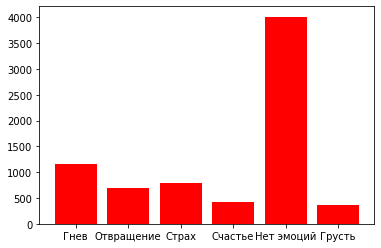

In [7]:
plt.figure(1)
plt.bar(classes_russ, height = hist_data,color = "r")
plt.savefig("img_example/hist_classes.png")
plt.show()

In [8]:
files = data_csv["FileName"]
files_wav = "AudioMP3/" + files + ".mp3"
files_video = "VideoFlash/" + files + ".flv"
len(files)

7442

In [9]:
files_video = files_video
files_wav = files_wav

Получение звуковых признаков: mfcc и мел спектрограмма

In [10]:
def my_resize(y, len_y):
    if(len(y) >= len_y):
        return y[0:len_y]
    else:
        return np.pad(y, [(0, len_y - len(y))], mode='constant', constant_values=0)

def mel_norm(mel):
    return 2*np.log(1 + mel) / np.log(1 + np.max(mel)) - 1

def mfcc_norm(mfcc):
    return 2*(mfcc - np.min(mfcc)) / (np.max(mfcc) - np.min(mfcc)) - 1

def get_audio_mfcc(files_wav):
    len_y = int(16e3*12) #median len (4608 + 2725632) / 2
    data_mfcc = []
    data_mel = []
    time = []
    warnings.filterwarnings('ignore')
    for i, file in enumerate(files_wav):

        cycl_persent = int((i+1)/len(files_wav)*100)
        print(cycl_persent, " %")


        y, sr = librosa.load(file, sr = None)
        time.append(len(y)/16e3)
        y = my_resize(y, len_y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                            fmax=16e3)
        data_mfcc.append(mfcc_norm(mfcc.astype("float32")))
        data_mel.append(mel_norm(mel.astype("float32")))
    return data_mel, data_mfcc, time
# data_mel, data_mfcc, time = get_audio_mfcc(files_wav)

# with open('data_pkl/data_mel.pkl', 'wb') as f:
#     pickle.dump(data_mel, f)


# with open('data_pkl/time.pkl', 'wb') as f:
#     pickle.dump(time, f)

# with open('data_pkl/data_mfcc.pkl', 'wb') as f:
#     pickle.dump(data_mfcc, f)


Распределение длительности звукозаписей по времени

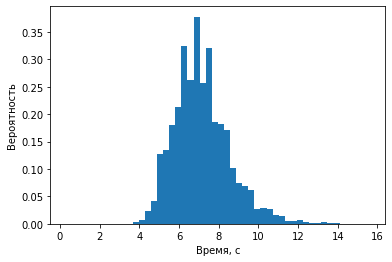

In [11]:

with open(r"data_pkl/time.pkl", "rb") as input_file:
    time = pickle.load(input_file)
time = np.array(time)
time[time == np.max(time)] = np.median(time)
plt.hist(time, density=True, bins=50)  # density=False would make counts
plt.ylabel('Вероятность')
plt.xlabel('Время, с')
plt.savefig("img_example/hist.png")

In [12]:
16e3*12

192000.0

Получение визуальных признаков

In [13]:
def convert_and_trim_bb(image, rect):
	# extract the starting and ending (x, y)-coordinates of the
	# bounding box
	startX = rect.left()
	startY = rect.top()
	endX = rect.right()
	endY = rect.bottom()
	# ensure the bounding box coordinates fall within the spatial
	# dimensions of the image
	startX = max(0, startX)
	startY = max(0, startY)
	endX = min(endX, image.shape[1])
	endY = min(endY, image.shape[0])
	# compute the width and height of the bounding box
	w = endX - startX
	h = endY - startY
	# return our bounding box coordinates
	return (startX, startY, w, h)

def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

def norm_landmarks(landmarks):
	eps = 1e-6
	landmarks = landmarks.astype("float32").T
	landmarks[0,:] -= np.min(landmarks[0,:])
	landmarks[1,:] -= np.min(landmarks[1,:])
	landmarks[0,:] /= np.max(landmarks[0,:]) + eps
	landmarks[1,:] /= np.max(landmarks[1,:]) + eps
	return 2*landmarks - 1

	

In [14]:
import time
# 3756
def get_face_from_vieo(files_video):

    arr_point = []
    arr_face = []
    cnt_png = 0
    timer = time.time()
    N = len(files_video)
    print("len ", len(files_video))
    for i in range(N):
        cycl_persent = int((i+1)/N*100)
        print(cycl_persent, " %")
        print(time.time() - timer, " s")
        timer = time.time()
        cap = cv2.VideoCapture(files_video[i])
        im = np.zeros((64,64,3), dtype = np.float32)
        cnt = 0
        cnt2 = 0
        print(i)
        while(cap.isOpened()):
            ret, frame = cap.read()
            cnt2 += 1
            if ret:
                if cnt2 % 5 != 0:
                    continue
                detector = dlib.get_frontal_face_detector()
                image = imutils.resize(frame, width=600)
                rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                rects = detector(rgb, 1)
                if len(rects) == 0:
                    img = np.zeros_like(image)
                    img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
                else:
                    box = [convert_and_trim_bb(rgb, r) for r in rects][0]
                    img = rgb[box[1]:box[1] + box[3], box[0]:box[0] + box[2],:]
                    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
                im += img/255
                cnt += 1
            else:
                break
        # plt.figure(1)
        # plt.imshow(im/cnt)
        # plt.show()
        # plt.imsave('img_example/'+ str(cnt_png) + '.png', im/cnt)
        # cnt_png += 1
        ln_img = im/cnt*255
        ln_img = cv2.cvtColor(ln_img.astype("uint8"), cv2.COLOR_BGR2GRAY)
        landmarks = extract_face_landmarks(ln_img.astype("uint8"))
        if landmarks is None:
            landmarks = np.zeros((62,2))
        arr_point.append(norm_landmarks(landmarks))

        arr_face.append(2*im/cnt - 1)
        cap.release()
    return arr_face, arr_point

# arr_face, arr_point = get_face_from_vieo(files_video)

# print(len(arr_face), " len")
# with open('data_pkl/arr_face.pkl', 'wb') as f:
#     pickle.dump(arr_face, f)

# with open('data_pkl/arr_point.pkl', 'wb') as f:
#     pickle.dump(arr_point, f)

In [15]:
with open(r"data_pkl/data_mfcc_all.pkl", "rb") as input_file:
    mfcc = pickle.load(input_file)
with open(r"data_pkl/data_mel_all.pkl", "rb") as input_file:
    mel = pickle.load(input_file)
with open(r"data_pkl/arr_point_all.pkl", "rb") as input_file:
    points = pickle.load(input_file)
with open(r"data_pkl/arr_face_all.pkl", "rb") as input_file:
    face = pickle.load(input_file)

Предобработка признаков: преобразование в вектор и удаление значения Nan

In [16]:
mfcc_copy = np.asarray(mfcc)
mfcc = np.zeros((len(mfcc_copy) , len(mfcc[0].reshape(-1))))
for i in range(len(mfcc)):
    mfcc[i] = mfcc_copy[i].flatten()
mfcc.shape

(7442, 7520)

In [17]:
mel_copy = np.asarray(mel)
mel = np.zeros((len(mel_copy) , len(mel[0].reshape(-1))))
for i in range(len(mel)):
    mel[i] = mel_copy[i].flatten()
mel.shape
mel[np.isnan(mel)] = 0

In [18]:
# points = np.array(points)
for i, p in enumerate(points):
    if p.shape == (2,62):
        points[i] = np.concatenate((points[i], np.zeros((2,6))), axis=1)


points_copy = np.asarray(points)
points = np.zeros((len(points_copy) , len(points[0].reshape(-1))))
for i in range(len(points)):
    points[i] = points_copy[i].flatten()
points.shape

(7442, 136)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
face_copy = np.asarray(face)
face = np.zeros((len(face_copy) , len(face[0].reshape(-1))))
for i in range(len(face)):
    face[i] = face_copy[i].flatten()
face.shape
face[np.isnan(face)] = 0

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [22]:
labels = shuffle(labels, random_state=20)
mfcc = shuffle(mfcc, random_state=20)
mel = shuffle(mel, random_state=20)
points = shuffle(points, random_state=20)
face = shuffle(face, random_state=20)

Разделение датасета на тестовую и тренеровочную выборку

In [23]:
def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return  X_train, X_test, y_train, y_test

In [24]:
mfcc_train, mfcc_test, y_train, y_test =  split(mfcc, labels)
mel_train, mel_test, y_train, y_test =  split(mfcc, labels)
points_train, points_test, y_train, y_test =  split(mfcc, labels)
face_train, face_test, y_train, y_test =  split(mfcc, labels)

In [25]:
# min_size = 1e10
# for i in range(6):
#     min_size = np.min([np.sum(labels == i), min_size])
# train_class_size = int(min_size*0.8)

In [26]:
# train_class_size

In [27]:
# labels_train = []
# labels_test = []

# mfcc_train = []
# mfcc_test = []

# mel_test = []
# mel_train= []

# points_test = []
# points_train= []

# face_train = []
# face_test = []

In [28]:
# class_counter = np.zeros(6)
# for i in range(len(labels)):
#     class_counter[labels[i]] += 1
#     if class_counter[labels[i]] > train_class_size:
#         labels_test.append(labels[i])
#         mfcc_test.append(mfcc[i])
#         mel_test.append(mel[i])
#         points_test.append(points[i])
#         face_test.append(face[i])
#     else:
#         labels_train.append(labels[i])
#         mfcc_train.append(mfcc[i])
#         mel_train.append(mel[i])
#         points_train.append(points[i])
#         face_train.append(face[i])



In [29]:
# mfcc_train = np.array(mfcc_train)
# mel_train = np.array(mel_train)
# points_train = np.array(points_train)
# face_train = np.array(face_train)
# labels_train = np.array(labels_train)
# mfcc_test= np.array(mfcc_test)
# mel_test = np.array(mel_test)
# points_test = np.array(points_test)
# face_test = np.array(face_test)
# labels_test = np.array(labels_test)

In [30]:
mfcc_train.shape

(4986, 7520)

In [31]:
mel_train.shape

(4986, 7520)

Конкатенация признаков

In [32]:

feach_train =  np.concatenate((mfcc_train, mel_train, points_train, face_train), axis=1)
feach_test =  np.concatenate((mfcc_test, mel_test, points_test, face_test), axis=1)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

Мфсс классификатор

In [34]:
svm_mfcc =  svm.SVC(gamma="auto", random_state= 20, probability=True, class_weight = "balanced")


svm_mfcc.fit(mfcc_train, y_train)


/home/liya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(class_weight='balanced', gamma='auto', probability=True, random_state=20)

In [35]:
p_mfcc = svm_mfcc.predict_proba(mfcc_test)
y_pred = np.argmax(p_mfcc, axis = 1)

acc_mfcc = f1_score(y_test, y_pred, average='macro')
print("f1: ", acc_mfcc)
print("accuracy score: ", accuracy_score(y_test, y_pred))



f1:  0.21557127875000603
accuracy score:  0.5944625407166124


Мел классификатор

In [36]:
svm_mel = svm.SVC( random_state= 20, probability=True, class_weight = "balanced")
svm_mel.fit(mel_train, y_train)


/home/liya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(class_weight='balanced', probability=True, random_state=20)

In [37]:
p_mel = svm_mel.predict_proba(mel_test)
y_pred = np.argmax(p_mel, axis = 1)

acc_mel = f1_score(y_test, y_pred, average='macro')
print("f1: ", acc_mel)
print("accuracy score: ", accuracy_score(y_test, y_pred))

f1:  0.24130698792245767
accuracy score:  0.619299674267101


Классификатор ключевых точек лица

In [38]:
svm_points = KNeighborsClassifier(n_neighbors=20, algorithm='ball_tree', metric='euclidean')
svm_points.fit(points_train, y_train)

/home/liya/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=20)

In [39]:
p_points = svm_points.predict_proba(points_test)
y_pred = np.argmax(p_points, axis = 1)

acc_points = f1_score(y_test, y_pred, average='macro')
print("f1: ", acc_points)
print("accuracy score: ", accuracy_score(y_test, y_pred))

f1:  0.22437084722886516
accuracy score:  0.5952768729641694


Классификатор лица

In [40]:
svm_face = svm.SVC(random_state= 20, probability=True, class_weight = "balanced")
svm_face.fit(face_train, y_train)


/home/liya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(class_weight='balanced', probability=True, random_state=20)

In [41]:
p_face = svm_face.predict_proba(face_test)
y_pred = np.argmax(p_face, axis = 1)

acc_face = f1_score(y_test, y_pred, average='macro')
print("f1: ", acc_face)
print("accuracy score: ", accuracy_score(y_test, y_pred))

f1:  0.24130698792245767
accuracy score:  0.619299674267101


Объединение классификаторов в ансамбль

In [42]:
sum_acc = acc_face + acc_mel + acc_mfcc + acc_points

In [43]:
pr_final = (p_mfcc * (acc_mfcc) +  p_mel * (acc_mel) + p_face * (acc_face) + p_points * (acc_points) )/sum_acc

In [44]:
y_pred = np.argmax(pr_final, axis = 1)

acc_final = f1_score(y_test, y_pred, average='macro')
print("f1: ", acc_final)
print("accuracy score: ", accuracy_score(y_test, y_pred))

f1:  0.22855865153078778
accuracy score:  0.6140065146579805


Обучение 2х классификаторов на объединенных признаках

In [45]:
svm_all =  svm.SVC(kernel= "poly",  random_state= 20, probability=True, class_weight = "balanced")
tree_all =  RandomForestClassifier(max_depth=200, n_estimators=100, class_weight = "balanced")



In [46]:
tree_all.fit(feach_train, y_train)

/tmp/ipykernel_31063/3189971335.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_all.fit(feach_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=200)

In [47]:
svm_all.fit(feach_train, y_train)

/home/liya/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(class_weight='balanced', kernel='poly', probability=True, random_state=20)

In [48]:
p_svm= svm_all.predict_proba(feach_test) 

In [49]:
y_pred = np.argmax(p_svm, axis = 1)
f1_svm =  f1_score(y_test, y_pred, average='macro')
print("accuracy score: ", accuracy_score(y_test, y_pred))

accuracy score:  0.635586319218241


In [50]:
p_tree= tree_all.predict_proba(feach_test) 

In [51]:
y_pred = np.argmax(p_tree, axis = 1)
f1_tree =  f1_score(y_test, y_pred, average='macro')
print("accuracy score: ", accuracy_score(y_test, y_pred))


accuracy score:  0.616042345276873


In [52]:
p_all = f1_svm * p_svm + f1_tree *p_tree

In [53]:
y_pred = np.argmax(p_all, axis = 1)

In [54]:

acc_feach = f1_score(y_test, y_pred, average='macro')
print("accuracy score: ", accuracy_score(y_test, y_pred))


accuracy score:  0.636400651465798


In [55]:
print("f1 all: ", acc_feach)
print("f1 tree: ", f1_tree)
print("f1 svm: ", f1_svm)

f1 all:  0.25982484939279
f1 tree:  0.23358300503051574
f1 svm:  0.28545492874170414


Подбор колличества деревьев и их глубины

In [56]:
f1 = []
n_estimators_my = [200, 800, 1400, 2000, 2600]
for i in range(len(n_estimators_my)):
    print(i)
    tree_all =  RandomForestClassifier(max_depth=200, n_estimators=n_estimators_my[i], class_weight = "balanced")
    tree_all.fit(feach_train, y_train)
    f1.append(f1_score(y_test, tree_all.predict(feach_test) , average='macro')) 



estimators_my = n_estimators_my[np.argmax(f1)]
print("best n_estimators: " , n_estimators_my[np.argmax(f1)])
print("best f1: " , np.max(f1))

0


/tmp/ipykernel_31063/4094544739.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_all.fit(feach_train, y_train)


1


/tmp/ipykernel_31063/4094544739.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_all.fit(feach_train, y_train)


2


/tmp/ipykernel_31063/4094544739.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_all.fit(feach_train, y_train)


3


/tmp/ipykernel_31063/4094544739.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_all.fit(feach_train, y_train)


4


/tmp/ipykernel_31063/4094544739.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_all.fit(feach_train, y_train)


best n_estimators:  800
best f1:  0.24117687197759421


best n_estimators:  800
best f1:  0.24117687197759421


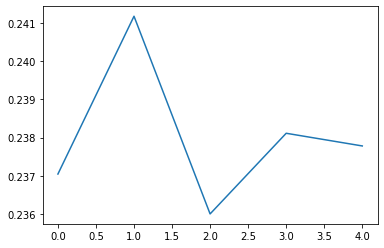

In [57]:
plt.plot(f1)
print("best n_estimators: " , n_estimators_my[np.argmax(f1)])
print("best f1: " , np.max(f1))

In [59]:
f1 = []
max_depth_my = [10, 173.33, 336.66, 500]
for i in range(len(max_depth_my)):
    print(i)
    tree_all =  RandomForestClassifier(max_depth=max_depth_my[i], n_estimators=estimators_my, class_weight = "balanced")
    tree_all.fit(feach_train, y_train)
    f1.append(f1_score(y_test, tree_all.predict(feach_test) , average='macro')) 


deth = max_depth_my[np.argmax(f1)]
print("best n_estimators: " , max_depth_my[np.argmax(f1)])
print("best f1: " , np.max(f1))

0


/tmp/ipykernel_31063/2332611052.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_all.fit(feach_train, y_train)


1


/tmp/ipykernel_31063/2332611052.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_all.fit(feach_train, y_train)


2


/tmp/ipykernel_31063/2332611052.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_all.fit(feach_train, y_train)


3


/tmp/ipykernel_31063/2332611052.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_all.fit(feach_train, y_train)


best n_estimators:  10
best f1:  0.31713606754150975


In [60]:
tree_all =  RandomForestClassifier(max_depth=deth, n_estimators= estimators_my, class_weight = "balanced")
tree_all.fit(feach_train, y_train)
p_tree= tree_all.predict_proba(feach_test) 
y_pred = np.argmax(p_tree, axis = 1)
f1_tree =  f1_score(y_test, y_pred, average='macro')

/tmp/ipykernel_31063/522804992.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_all.fit(feach_train, y_train)


Финальный классификатор

In [61]:
p_all = f1_svm * p_svm + f1_tree *p_tree
y_pred = np.argmax(p_all, axis = 1)
acc_feach = f1_score(y_test, y_pred, average='macro')
print("f1 final: ", acc_feach)
print("accuracy score: ", accuracy_score(y_test, y_pred))

f1 final:  0.28183242824968857
accuracy score:  0.6319218241042345
